# HW3 Image Classification
## We strongly recommend that you run with Kaggle for this homework
https://www.kaggle.com/c/ml2022spring-hw3b/code?competitionId=34954&sortBy=dateCreated

# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.


In [1]:
# ! wget https://www.dropbox.com/s/6l2vcvxl54b0b6w/food11.zip  -O food11.zip
! echo "get data"

get data


In [2]:
# ! unzip food11.zip
! echo "unzip"

unzip


# Training

## Subset
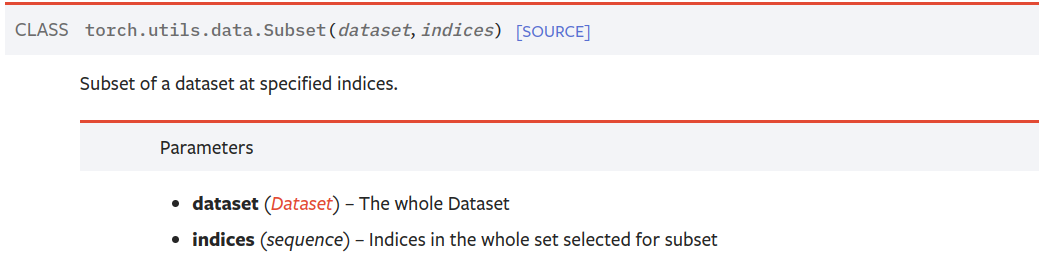

## ConcatDataset
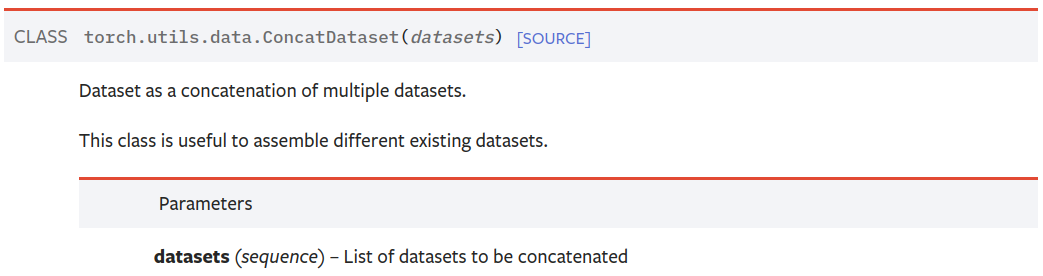

In [3]:
_exp_name = "sample"

In [4]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random

torch.backends.cudnn.deterministic是啥？顧名思義，將這個flag 置為True的話，每次返回的捲積算法將是確定的，即默認算法。如果配合上設置Torch 的隨機種子為固定值的話，應該可以保證每次運行網絡的時候相同輸入的輸出是固定的

benchmark 設置False，是為了保證不使用選擇卷積算法的機制，使用固定的捲積算法。但是，就算是固定的捲積算法，由於其實現不同，也可能是不可控制的，即相同的值，同一個算法卷積出來有細微差別，deterministic設置True保證使用確定性的捲積算法，二者配合起來，才能保證卷積操作的一致性

In [5]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## **Label Smoothing**
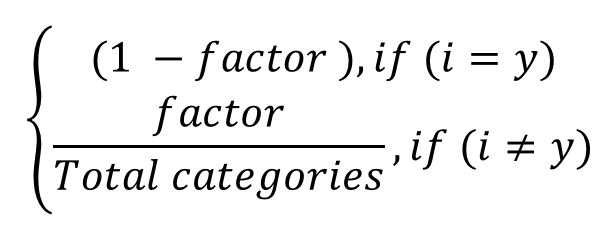

In [6]:
y = np.zeros(11, dtype='float32')
y[0] = 1
y = torch.FloatTensor(y)

def label_smoothing(labels, factor=0.1):
    c = torch.count_nonzero(labels)    
    labels *= (1 - factor)
    labels += (factor / (labels.shape[0] - c))
    return labels

label_smoothing(y)

tensor([0.9100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100])

## **Image Normalization**

In [7]:
from matplotlib import pyplot as plt
img_path = './food11/test/0001.jpg'
img = Image.open(img_path)
 
# convert PIL image to numpy array
img_np = np.array(img)

transform = transforms.Compose([
    transforms.ToTensor()
])
 
# transform the pIL image to tensor
# image
img_tr = transform(img)

Text(0.5, 1.0, 'distribution of pixels')

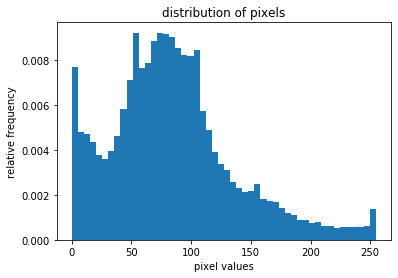

In [8]:
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

Text(0.5, 1.0, 'distribution of pixels')

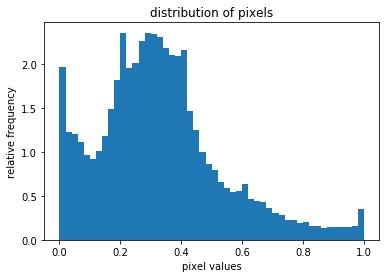

In [9]:
# transform the pIL image to tensor
# image
img_tr = transform(img)
 
# Convert tensor image to numpy array
img_np = np.array(img_tr)
 
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [10]:
# calculate mean and std
# 計算了紅色、綠色和藍色三個通道的圖像的平均值和標準差
mean, std = img_tr.mean([1,2]), img_tr.std([1,2])
 
# print mean and std
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.4206, 0.3150, 0.2571])
Std of the image: tensor([0.2228, 0.1709, 0.1828])


Text(0.5, 1.0, 'distribution of pixels')

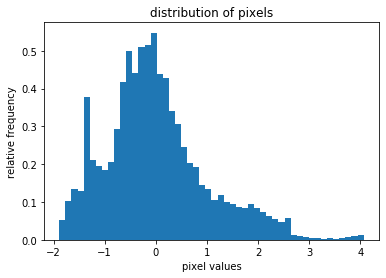

In [11]:
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
 
# get normalized image
img_normalized = transform_norm(img)
 
# convert normalized image to numpy
# array
img_np = np.array(img_normalized)
 
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

## **Transforms**
Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [12]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    transforms.Normalize(mean, std)
])

train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    transforms.RandomHorizontalFlip(),
    
    transforms.ColorJitter(brightness=(0.5,0.9)),
    transforms.ColorJitter(contrast=(0.5,0.9)),
    transforms.ColorJitter(saturation=(0.5,0.9)),
    transforms.ColorJitter(hue=(-0.2,0.2)),
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    transforms.Normalize(mean, std)
])

# origin: 0.33085

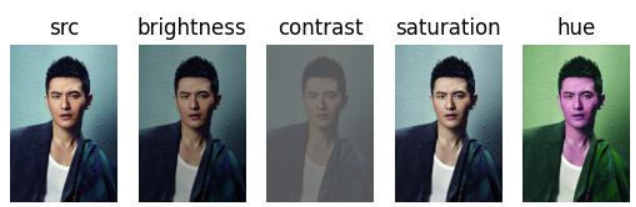

## **Datasets**
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [13]:
batch_size = 64
alpha = 2

class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)  
        
        y = np.zeros(11, dtype='float32')
                
        try:
            label = int(fname.split("/")[-1].split("_")[0])            
            y[label] = 1
            y = label_smoothing(y)
        except:
            label = -1 # test has no label                    
            
        im = self.transform(im)
        return im,y 

In [14]:
_dataset_dir = "./food11"
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
valid_set = FoodDataset(os.path.join(_dataset_dir,"validation"), tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

One ./food11/validation sample ./food11/validation/0_0.jpg


In [15]:
train_set = FoodDataset(os.path.join(_dataset_dir,"training"), tfm=train_tfm)
loader1 = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
loader2 = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

One ./food11/training sample ./food11/training/0_0.jpg


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]
            # nn.Dropout(0.2),

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]
            # nn.Dropout(0.2),

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]
            # nn.Dropout(0.2),

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            # nn.Dropout(0.2),
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
            # nn.Dropout(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            # nn.Dropout(0.2),
            nn.ReLU(),            
            nn.Linear(1024, 512),
            # nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512, 11),            
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)
    
model = Classifier().to(device)    

In [17]:
def criterion(input, target, size_average=True):
    """Categorical cross-entropy with logits input and one-hot target"""
    l = -(target * torch.log(F.softmax(input, dim=1) + 1e-10)).sum(1)
    if size_average:
        l = l.mean()
    else:
        l = l.sum()
    return l

In [18]:
from torch.autograd import Variable
import torch.nn.functional as F

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# The number of training epochs and patience.
n_epochs = 40
patience = 300 # If no improvement in 'patience' epochs, early stop

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5) 

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
       
    for (x1, y1), (x2, y2) in tqdm(zip(loader1, loader2)):
        # random generate mixup alpha
        lam = np.random.beta(alpha, alpha)
        # mixup
        imgs = Variable(lam*x1 + (1. - lam)*x2)
        labels = Variable(lam*y1 + (1. - lam)*y2)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        pred = logits.data.max(1, keepdim=True)[1].cpu()             
        labels = labels.max(1, keepdim=True)[1].data.view_as(pred).cpu()         
        acc = (pred == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        pred = logits.data.max(1, keepdim=True)[1].cpu()             
        labels = labels.max(1, keepdim=True)[1].data.view_as(pred).cpu()         
        acc = (pred == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break


[ Train | 001/040 ] loss = 2.23101, acc = 0.21353



[ Valid | 001/040 ] loss = 2.27207, acc = 0.23424
[ Valid | 001/040 ] loss = 2.27207, acc = 0.23424 -> best
Best model found at epoch 0, saving model



[ Train | 002/040 ] loss = 2.12996, acc = 0.26998



[ Valid | 002/040 ] loss = 2.45682, acc = 0.23386
[ Valid | 002/040 ] loss = 2.45682, acc = 0.23386



[ Train | 003/040 ] loss = 2.08289, acc = 0.29875



[ Valid | 003/040 ] loss = 2.13052, acc = 0.26008
[ Valid | 003/040 ] loss = 2.13052, acc = 0.26008 -> best
Best model found at epoch 2, saving model



[ Train | 004/040 ] loss = 2.00237, acc = 0.34972



[ Valid | 004/040 ] loss = 1.90034, acc = 0.32432
[ Valid | 004/040 ] loss = 1.90034, acc = 0.32432 -> best
Best model found at epoch 3, saving model



[ Train | 005/040 ] loss = 1.96972, acc = 0.37169



[ Valid | 005/040 ] loss = 1.77790, acc = 0.37707
[ Valid | 005/040 ] loss = 1.77790, acc = 0.37707 -> best
Best model found at epoch 4, saving model



[ Train | 006/040 ] loss = 1.93742, acc = 0.39210



[ Valid | 006/040 ] loss = 1.72882, acc = 0.39318
[ Valid | 006/040 ] loss = 1.72882, acc = 0.39318 -> best
Best model found at epoch 5, saving model



[ Train | 007/040 ] loss = 1.90497, acc = 0.40478



[ Valid | 007/040 ] loss = 1.62605, acc = 0.42743
[ Valid | 007/040 ] loss = 1.62605, acc = 0.42743 -> best
Best model found at epoch 6, saving model



[ Train | 008/040 ] loss = 1.85444, acc = 0.43480



[ Valid | 008/040 ] loss = 1.75135, acc = 0.41396
[ Valid | 008/040 ] loss = 1.75135, acc = 0.41396



[ Train | 009/040 ] loss = 1.84404, acc = 0.45091



[ Valid | 009/040 ] loss = 1.88129, acc = 0.36949
[ Valid | 009/040 ] loss = 1.88129, acc = 0.36949



[ Train | 010/040 ] loss = 1.81526, acc = 0.46331



[ Valid | 010/040 ] loss = 1.66945, acc = 0.41953
[ Valid | 010/040 ] loss = 1.66945, acc = 0.41953



[ Train | 011/040 ] loss = 1.77318, acc = 0.48649



[ Valid | 011/040 ] loss = 1.57549, acc = 0.46478
[ Valid | 011/040 ] loss = 1.57549, acc = 0.46478 -> best
Best model found at epoch 10, saving model



[ Train | 012/040 ] loss = 1.75439, acc = 0.49014



[ Valid | 012/040 ] loss = 1.42714, acc = 0.50906
[ Valid | 012/040 ] loss = 1.42714, acc = 0.50906 -> best
Best model found at epoch 11, saving model



[ Train | 013/040 ] loss = 1.74595, acc = 0.50627



[ Valid | 013/040 ] loss = 1.53623, acc = 0.47897
[ Valid | 013/040 ] loss = 1.53623, acc = 0.47897



[ Train | 014/040 ] loss = 1.71232, acc = 0.51746



[ Valid | 014/040 ] loss = 1.55661, acc = 0.47445
[ Valid | 014/040 ] loss = 1.55661, acc = 0.47445



[ Train | 015/040 ] loss = 1.69530, acc = 0.53060



[ Valid | 015/040 ] loss = 1.55989, acc = 0.45168
[ Valid | 015/040 ] loss = 1.55989, acc = 0.45168



[ Train | 016/040 ] loss = 1.67090, acc = 0.54554



[ Valid | 016/040 ] loss = 1.52843, acc = 0.48303
[ Valid | 016/040 ] loss = 1.52843, acc = 0.48303



[ Train | 017/040 ] loss = 1.65879, acc = 0.54516



[ Valid | 017/040 ] loss = 1.59055, acc = 0.45079
[ Valid | 017/040 ] loss = 1.59055, acc = 0.45079



[ Train | 018/040 ] loss = 1.63487, acc = 0.56179



[ Valid | 018/040 ] loss = 1.34663, acc = 0.57474
[ Valid | 018/040 ] loss = 1.34663, acc = 0.57474 -> best
Best model found at epoch 17, saving model



[ Train | 019/040 ] loss = 1.61672, acc = 0.57448



[ Valid | 019/040 ] loss = 1.36953, acc = 0.53280
[ Valid | 019/040 ] loss = 1.36953, acc = 0.53280



[ Train | 020/040 ] loss = 1.59804, acc = 0.58980



[ Valid | 020/040 ] loss = 1.48640, acc = 0.50231
[ Valid | 020/040 ] loss = 1.48640, acc = 0.50231



[ Train | 021/040 ] loss = 1.62137, acc = 0.58232



[ Valid | 021/040 ] loss = 1.41796, acc = 0.51978
[ Valid | 021/040 ] loss = 1.41796, acc = 0.51978



[ Train | 022/040 ] loss = 1.59556, acc = 0.59530



[ Valid | 022/040 ] loss = 1.50409, acc = 0.50859
[ Valid | 022/040 ] loss = 1.50409, acc = 0.50859



[ Train | 023/040 ] loss = 1.56482, acc = 0.60111



[ Valid | 023/040 ] loss = 1.27689, acc = 0.59290
[ Valid | 023/040 ] loss = 1.27689, acc = 0.59290 -> best
Best model found at epoch 22, saving model



[ Train | 024/040 ] loss = 1.55900, acc = 0.61359



[ Valid | 024/040 ] loss = 1.40058, acc = 0.54101
[ Valid | 024/040 ] loss = 1.40058, acc = 0.54101



[ Train | 025/040 ] loss = 1.53595, acc = 0.63484



[ Valid | 025/040 ] loss = 1.34684, acc = 0.55472
[ Valid | 025/040 ] loss = 1.34684, acc = 0.55472



[ Train | 026/040 ] loss = 1.52743, acc = 0.64048



[ Valid | 026/040 ] loss = 1.49828, acc = 0.49635
[ Valid | 026/040 ] loss = 1.49828, acc = 0.49635



[ Train | 027/040 ] loss = 1.49062, acc = 0.65401



[ Valid | 027/040 ] loss = 1.57317, acc = 0.47413
[ Valid | 027/040 ] loss = 1.57317, acc = 0.47413



[ Train | 028/040 ] loss = 1.47459, acc = 0.67038



[ Valid | 028/040 ] loss = 1.49089, acc = 0.51304
[ Valid | 028/040 ] loss = 1.49089, acc = 0.51304



[ Train | 029/040 ] loss = 1.48836, acc = 0.65913



[ Valid | 029/040 ] loss = 1.47677, acc = 0.50483
[ Valid | 029/040 ] loss = 1.47677, acc = 0.50483



[ Train | 030/040 ] loss = 1.47274, acc = 0.66409



[ Valid | 030/040 ] loss = 1.35246, acc = 0.56137
[ Valid | 030/040 ] loss = 1.35246, acc = 0.56137



[ Train | 031/040 ] loss = 1.40267, acc = 0.69823



[ Valid | 031/040 ] loss = 1.45649, acc = 0.53232
[ Valid | 031/040 ] loss = 1.45649, acc = 0.53232



[ Train | 032/040 ] loss = 1.45533, acc = 0.67538



[ Valid | 032/040 ] loss = 1.44246, acc = 0.52208
[ Valid | 032/040 ] loss = 1.44246, acc = 0.52208



[ Train | 033/040 ] loss = 1.38579, acc = 0.71323



[ Valid | 033/040 ] loss = 1.29449, acc = 0.58632
[ Valid | 033/040 ] loss = 1.29449, acc = 0.58632



[ Train | 034/040 ] loss = 1.39384, acc = 0.71524



[ Valid | 034/040 ] loss = 1.45139, acc = 0.52761
[ Valid | 034/040 ] loss = 1.45139, acc = 0.52761



[ Train | 035/040 ] loss = 1.40381, acc = 0.69433



[ Valid | 035/040 ] loss = 1.42020, acc = 0.53586
[ Valid | 035/040 ] loss = 1.42020, acc = 0.53586



[ Train | 036/040 ] loss = 1.37706, acc = 0.71661



[ Valid | 036/040 ] loss = 1.27495, acc = 0.58836
[ Valid | 036/040 ] loss = 1.27495, acc = 0.58836



[ Train | 037/040 ] loss = 1.35679, acc = 0.73573



[ Valid | 037/040 ] loss = 1.34899, acc = 0.56212
[ Valid | 037/040 ] loss = 1.34899, acc = 0.56212



[ Train | 038/040 ] loss = 1.34812, acc = 0.74034



[ Valid | 038/040 ] loss = 1.48056, acc = 0.52855
[ Valid | 038/040 ] loss = 1.48056, acc = 0.52855



[ Train | 039/040 ] loss = 1.32937, acc = 0.75232



[ Valid | 039/040 ] loss = 1.29826, acc = 0.58559
[ Valid | 039/040 ] loss = 1.29826, acc = 0.58559



[ Train | 040/040 ] loss = 1.26511, acc = 0.77093



[ Valid | 040/040 ] loss = 1.20805, acc = 0.61209
[ Valid | 040/040 ] loss = 1.20805, acc = 0.61209 -> best
Best model found at epoch 39, saving model


In [19]:
test_set = FoodDataset(os.path.join(_dataset_dir,"test"), tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

One ./food11/test sample ./food11/test/0001.jpg


# Testing and generate prediction CSV + Ensemble

In [20]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in tqdm(test_loader):
        # Ensemble(5)
        test_pred_list = []
        for i in range(5):
            test_pred = model_best(data.to(device)).unsqueeze(0)
            test_pred_list.append(test_pred)  
        test_pred = torch.cat(test_pred_list)
        test_pred = test_pred.sum(0) / test_pred.shape[0]
            
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

In [21]:
#create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(1,len(test_set)+1)]
df["Category"] = prediction
df.to_csv("submission.csv",index = False)

In [22]:
df.head()

,Id,Category
0,0001,4
1,0002,9
2,0003,0
3,0004,3
4,0005,2


# Focal Loss
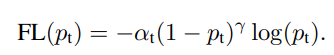

In [23]:
class WeightedFocalLoss(nn.Module):
    "Non weighted version of Focal Loss"    
    def __init__(self, alpha=.25, gamma=2):
            super(WeightedFocalLoss, self).__init__()        
            self.alpha = torch.tensor([alpha, 1-alpha]).cuda()        
            self.gamma = gamma
            
    def forward(self, inputs, targets):
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets)        
            targets = targets.type(torch.long)        
            at = self.alpha.gather(0, targets.data.view(-1))        
            pt = torch.exp(-BCE_loss)        
            F_loss = at*(1-pt)**self.gamma * BCE_loss        
            return F_loss.mean()

In [24]:
model = Classifier().to(device)    
criterion = WeightedFocalLoss()

In [25]:
from torch.autograd import Variable
import torch.nn.functional as F

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# The number of training epochs and patience.
n_epochs = 40
patience = 300 # If no improvement in 'patience' epochs, early stop

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5) 

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
       
    for (x1, y1), (x2, y2) in tqdm(zip(loader1, loader2)):
        # random generate mixup alpha
        lam = np.random.beta(alpha, alpha)
        # mixup
        imgs = Variable(lam*x1 + (1. - lam)*x2)
        labels = Variable(lam*y1 + (1. - lam)*y2)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        pred = logits.data.max(1, keepdim=True)[1].cpu()             
        labels = labels.max(1, keepdim=True)[1].data.view_as(pred).cpu()         
        acc = (pred == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        pred = logits.data.max(1, keepdim=True)[1].cpu()             
        labels = labels.max(1, keepdim=True)[1].data.view_as(pred).cpu()         
        acc = (pred == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break


[ Train | 001/040 ] loss = 0.00510, acc = 0.20562



[ Valid | 001/040 ] loss = 0.00541, acc = 0.22323
[ Valid | 001/040 ] loss = 0.00541, acc = 0.22323 -> best
Best model found at epoch 0, saving model



[ Train | 002/040 ] loss = 0.00420, acc = 0.27266



[ Valid | 002/040 ] loss = 0.00469, acc = 0.30041
[ Valid | 002/040 ] loss = 0.00469, acc = 0.30041 -> best
Best model found at epoch 1, saving model



[ Train | 003/040 ] loss = 0.00394, acc = 0.31196



[ Valid | 003/040 ] loss = 0.00495, acc = 0.28267
[ Valid | 003/040 ] loss = 0.00495, acc = 0.28267



[ Train | 004/040 ] loss = 0.00375, acc = 0.33448



[ Valid | 004/040 ] loss = 0.00353, acc = 0.35595
[ Valid | 004/040 ] loss = 0.00353, acc = 0.35595 -> best
Best model found at epoch 3, saving model



[ Train | 005/040 ] loss = 0.00361, acc = 0.35069



[ Valid | 005/040 ] loss = 0.00454, acc = 0.27543
[ Valid | 005/040 ] loss = 0.00454, acc = 0.27543



[ Train | 006/040 ] loss = 0.00347, acc = 0.37950



[ Valid | 006/040 ] loss = 0.00317, acc = 0.36001
[ Valid | 006/040 ] loss = 0.00317, acc = 0.36001 -> best
Best model found at epoch 5, saving model



[ Train | 007/040 ] loss = 0.00328, acc = 0.40804



[ Valid | 007/040 ] loss = 0.00516, acc = 0.29316
[ Valid | 007/040 ] loss = 0.00516, acc = 0.29316



[ Train | 008/040 ] loss = 0.00321, acc = 0.41454



[ Valid | 008/040 ] loss = 0.00329, acc = 0.38779
[ Valid | 008/040 ] loss = 0.00329, acc = 0.38779 -> best
Best model found at epoch 7, saving model



[ Train | 009/040 ] loss = 0.00308, acc = 0.43456



[ Valid | 009/040 ] loss = 0.00240, acc = 0.45584
[ Valid | 009/040 ] loss = 0.00240, acc = 0.45584 -> best
Best model found at epoch 8, saving model



[ Train | 010/040 ] loss = 0.00308, acc = 0.43611



[ Valid | 010/040 ] loss = 0.00230, acc = 0.47702
[ Valid | 010/040 ] loss = 0.00230, acc = 0.47702 -> best
Best model found at epoch 9, saving model



[ Train | 011/040 ] loss = 0.00300, acc = 0.45192



[ Valid | 011/040 ] loss = 0.00338, acc = 0.40065
[ Valid | 011/040 ] loss = 0.00338, acc = 0.40065



[ Train | 012/040 ] loss = 0.00296, acc = 0.45460



[ Valid | 012/040 ] loss = 0.00209, acc = 0.50676
[ Valid | 012/040 ] loss = 0.00209, acc = 0.50676 -> best
Best model found at epoch 11, saving model



[ Train | 013/040 ] loss = 0.00291, acc = 0.46077



[ Valid | 013/040 ] loss = 0.00259, acc = 0.44566
[ Valid | 013/040 ] loss = 0.00259, acc = 0.44566



[ Train | 014/040 ] loss = 0.00297, acc = 0.45073



[ Valid | 014/040 ] loss = 0.00227, acc = 0.49324
[ Valid | 014/040 ] loss = 0.00227, acc = 0.49324



[ Train | 015/040 ] loss = 0.00286, acc = 0.46623



[ Valid | 015/040 ] loss = 0.00210, acc = 0.52519
[ Valid | 015/040 ] loss = 0.00210, acc = 0.52519 -> best
Best model found at epoch 14, saving model



[ Train | 016/040 ] loss = 0.00279, acc = 0.47889



[ Valid | 016/040 ] loss = 0.00227, acc = 0.49411
[ Valid | 016/040 ] loss = 0.00227, acc = 0.49411



[ Train | 017/040 ] loss = 0.00278, acc = 0.48454



[ Valid | 017/040 ] loss = 0.00252, acc = 0.45993
[ Valid | 017/040 ] loss = 0.00252, acc = 0.45993



[ Train | 018/040 ] loss = 0.00271, acc = 0.50329



[ Valid | 018/040 ] loss = 0.00320, acc = 0.40121
[ Valid | 018/040 ] loss = 0.00320, acc = 0.40121



[ Train | 019/040 ] loss = 0.00268, acc = 0.50159



[ Valid | 019/040 ] loss = 0.00422, acc = 0.36399
[ Valid | 019/040 ] loss = 0.00422, acc = 0.36399



[ Train | 020/040 ] loss = 0.00263, acc = 0.50190



[ Valid | 020/040 ] loss = 0.00418, acc = 0.35173
[ Valid | 020/040 ] loss = 0.00418, acc = 0.35173



[ Train | 021/040 ] loss = 0.00257, acc = 0.51367



[ Valid | 021/040 ] loss = 0.00225, acc = 0.47193
[ Valid | 021/040 ] loss = 0.00225, acc = 0.47193



[ Train | 022/040 ] loss = 0.00257, acc = 0.51897



[ Valid | 022/040 ] loss = 0.00237, acc = 0.47056
[ Valid | 022/040 ] loss = 0.00237, acc = 0.47056



[ Train | 023/040 ] loss = 0.00254, acc = 0.52256



[ Valid | 023/040 ] loss = 0.00249, acc = 0.46132
[ Valid | 023/040 ] loss = 0.00249, acc = 0.46132



[ Train | 024/040 ] loss = 0.00250, acc = 0.52669



[ Valid | 024/040 ] loss = 0.00257, acc = 0.44349
[ Valid | 024/040 ] loss = 0.00257, acc = 0.44349



[ Train | 025/040 ] loss = 0.00246, acc = 0.52740



[ Valid | 025/040 ] loss = 0.00274, acc = 0.44045
[ Valid | 025/040 ] loss = 0.00274, acc = 0.44045



[ Train | 026/040 ] loss = 0.00244, acc = 0.54167



[ Valid | 026/040 ] loss = 0.00176, acc = 0.55933
[ Valid | 026/040 ] loss = 0.00176, acc = 0.55933 -> best
Best model found at epoch 25, saving model



[ Train | 027/040 ] loss = 0.00242, acc = 0.55157



[ Valid | 027/040 ] loss = 0.00323, acc = 0.39098
[ Valid | 027/040 ] loss = 0.00323, acc = 0.39098



[ Train | 028/040 ] loss = 0.00240, acc = 0.55145



[ Valid | 028/040 ] loss = 0.00198, acc = 0.52459
[ Valid | 028/040 ] loss = 0.00198, acc = 0.52459



[ Train | 029/040 ] loss = 0.00234, acc = 0.55808



[ Valid | 029/040 ] loss = 0.00223, acc = 0.50105
[ Valid | 029/040 ] loss = 0.00223, acc = 0.50105



[ Train | 030/040 ] loss = 0.00233, acc = 0.56298



[ Valid | 030/040 ] loss = 0.00432, acc = 0.34693
[ Valid | 030/040 ] loss = 0.00432, acc = 0.34693



[ Train | 031/040 ] loss = 0.00236, acc = 0.55284



[ Valid | 031/040 ] loss = 0.00163, acc = 0.55623
[ Valid | 031/040 ] loss = 0.00163, acc = 0.55623



[ Train | 032/040 ] loss = 0.00228, acc = 0.56732



[ Valid | 032/040 ] loss = 0.00180, acc = 0.54025
[ Valid | 032/040 ] loss = 0.00180, acc = 0.54025



[ Train | 033/040 ] loss = 0.00223, acc = 0.57889



[ Valid | 033/040 ] loss = 0.00202, acc = 0.51253
[ Valid | 033/040 ] loss = 0.00202, acc = 0.51253



[ Train | 034/040 ] loss = 0.00228, acc = 0.56524



[ Valid | 034/040 ] loss = 0.00158, acc = 0.56145
[ Valid | 034/040 ] loss = 0.00158, acc = 0.56145 -> best
Best model found at epoch 33, saving model



[ Train | 035/040 ] loss = 0.00227, acc = 0.58044



[ Valid | 035/040 ] loss = 0.00338, acc = 0.40901
[ Valid | 035/040 ] loss = 0.00338, acc = 0.40901



[ Train | 036/040 ] loss = 0.00212, acc = 0.59921



[ Valid | 036/040 ] loss = 0.00193, acc = 0.55412
[ Valid | 036/040 ] loss = 0.00193, acc = 0.55412



[ Train | 037/040 ] loss = 0.00209, acc = 0.59742



[ Valid | 037/040 ] loss = 0.00141, acc = 0.58355
[ Valid | 037/040 ] loss = 0.00141, acc = 0.58355 -> best
Best model found at epoch 36, saving model



[ Train | 038/040 ] loss = 0.00218, acc = 0.59149



[ Valid | 038/040 ] loss = 0.00192, acc = 0.51844
[ Valid | 038/040 ] loss = 0.00192, acc = 0.51844



[ Train | 039/040 ] loss = 0.00204, acc = 0.61988



[ Valid | 039/040 ] loss = 0.00155, acc = 0.56695
[ Valid | 039/040 ] loss = 0.00155, acc = 0.56695



[ Train | 040/040 ] loss = 0.00207, acc = 0.60589



[ Valid | 040/040 ] loss = 0.00162, acc = 0.55029
[ Valid | 040/040 ] loss = 0.00162, acc = 0.55029
